<a href="https://colab.research.google.com/github/TejashreeGanesan/Fake-News-Detection-An-ensemble-approach/blob/main/Fake_News_detection_using_LSTM_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Load the Fake and True news data
fake_df = pd.read_csv('Fake.csv')  # Replace with the correct path to Fake.csv
true_df = pd.read_csv('True.csv')  # Replace with the correct path to True.csv

# Step 2: Preprocess the data
def clean_text(text):
    """Clean the text by removing special characters, numbers, and extra spaces."""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabet characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

# Clean the text in both datasets
fake_df['text'] = fake_df['text'].apply(clean_text)
true_df['text'] = true_df['text'].apply(clean_text)

# Step 3: Assign labels: 0 for fake, 1 for real
fake_df['label'] = 0  # Fake news is labeled as 0
true_df['label'] = 1  # Real news is labeled as 1

# Combine the datasets
df = pd.concat([fake_df[['text', 'label']], true_df[['text', 'label']]], axis=0)

# Step 4: Split data into train and test sets
X = df['text']
y = df['label']

# Split the data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100  # Max sequence length (to reduce computation time)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Step 6: Build the LSTM model with L2 Regularization, Increased Dropout, and Early Stopping
def create_lstm_model(input_dim, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=max_len))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.02)))  # Reduced LSTM units, increased dropout, stronger L2 regularization
    model.add(Dropout(0.3))  # Additional Dropout Layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])  # Lower learning rate
    return model

lstm_model = create_lstm_model(input_dim=5000, max_len=max_len)

# Step 7: Train the LSTM model with Early Stopping and store history
history = lstm_model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Now you can access the history of training metrics
print(history.history.keys())  # This will give you a list of available metrics in the history

# Step 8: Get LSTM embeddings
lstm_embeddings_train = lstm_model.predict(X_train_pad)
lstm_embeddings_test = lstm_model.predict(X_test_pad)

# Step 9: Train Random Forest on LSTM embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(lstm_embeddings_train, y_train)

# Step 10: Cross-validation on the Random Forest model
cross_val_scores = cross_val_score(rf_model, lstm_embeddings_test, y_test, cv=5)
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.2f} ± {cross_val_scores.std():.2f}")

# Step 11: Make predictions with the Random Forest model
y_pred = rf_model.predict(lstm_embeddings_test)

# Step 12: Evaluate the model
print("Evaluation on test data:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 93s 173ms/step - accuracy: 0.8373 - loss: 1.5635 - val_accuracy: 0.9594 - val_loss: 0.1863
Epoch 2/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - accuracy: 0.9579 - loss: 0.1743 - val_accuracy: 0.9646 - val_loss: 0.1323
Epoch 3/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 141s 171ms/step - accuracy: 0.9671 - loss: 0.1299 - val_accuracy: 0.9702 - val_loss: 0.1199
Epoch 4/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 86s 169ms/step - accuracy: 0.9725 - loss: 0.1099 - val_accuracy: 0.9741 - val_loss: 0.1034
Epoch 5/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 150s 185ms/step - accuracy: 0.9778 - loss: 0.0963 - val_accuracy: 0.9713 - val_loss: 0.1064
Epoch 6/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 135s 171ms/step - accuracy: 0.9764 - loss: 0.0923 - val_accuracy: 0.9730 - val_loss: 0.1026
Epoch 7/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 171ms/step - accuracy: 0.9799 - loss: 0.0819 - val_accuracy: 0.9708 - val_loss: 0.1060
Epoch 8/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 171ms/step - accuracy: 0.9844 - l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

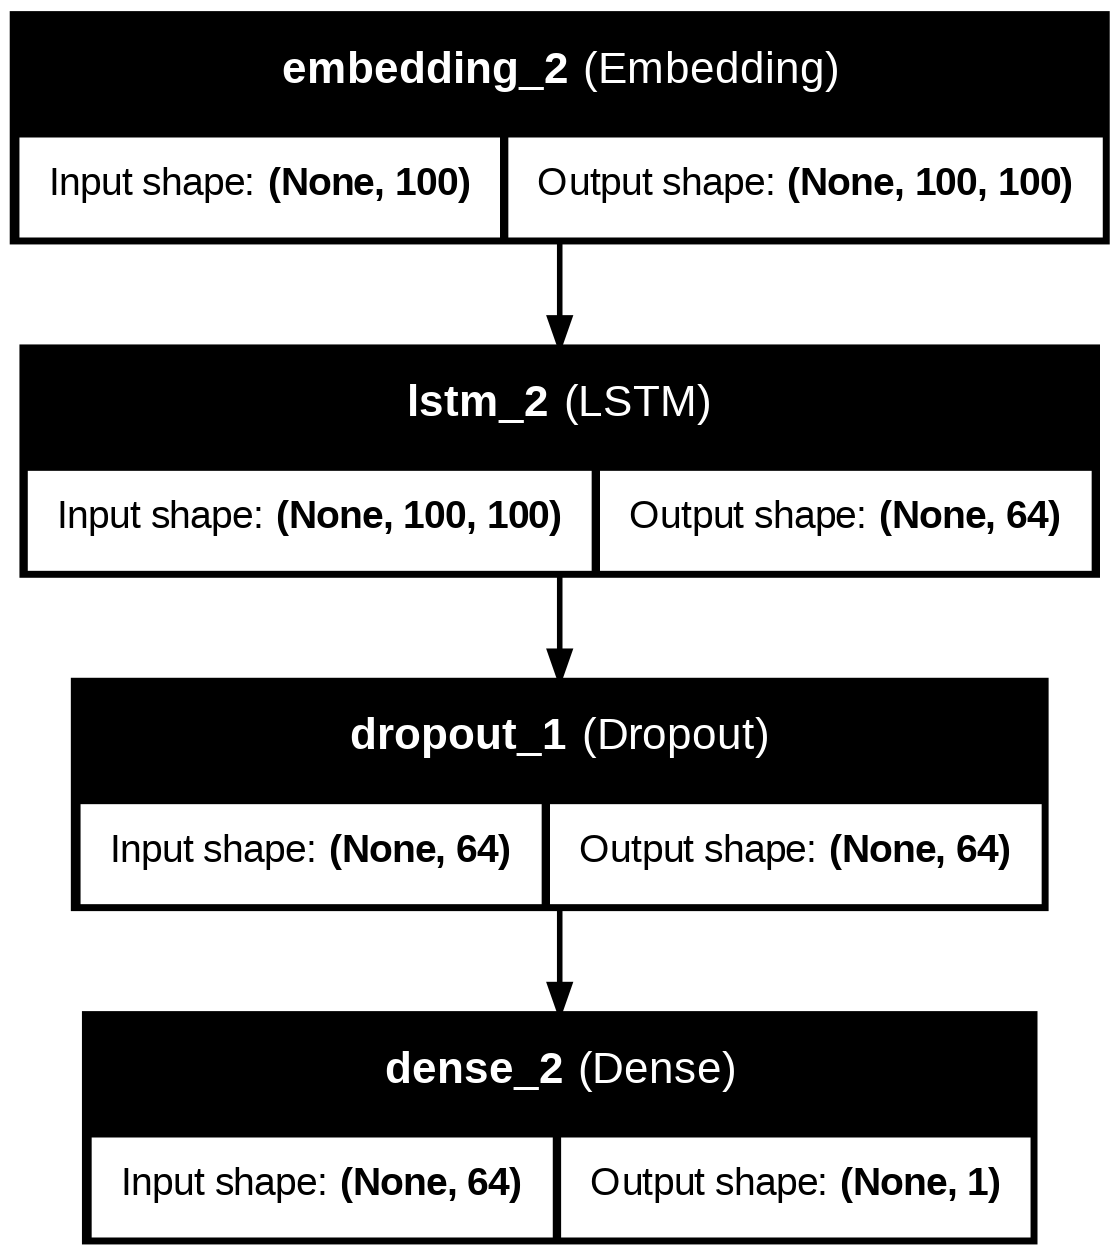

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(lstm_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


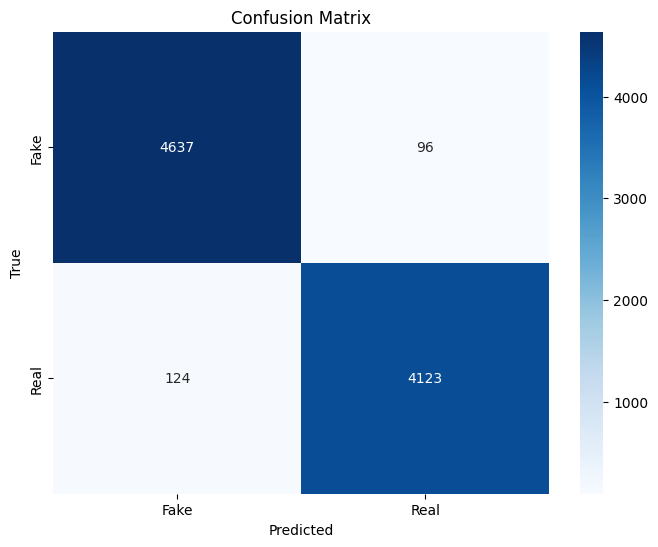

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix
y_pred = rf_model.predict(lstm_embeddings_test)
cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


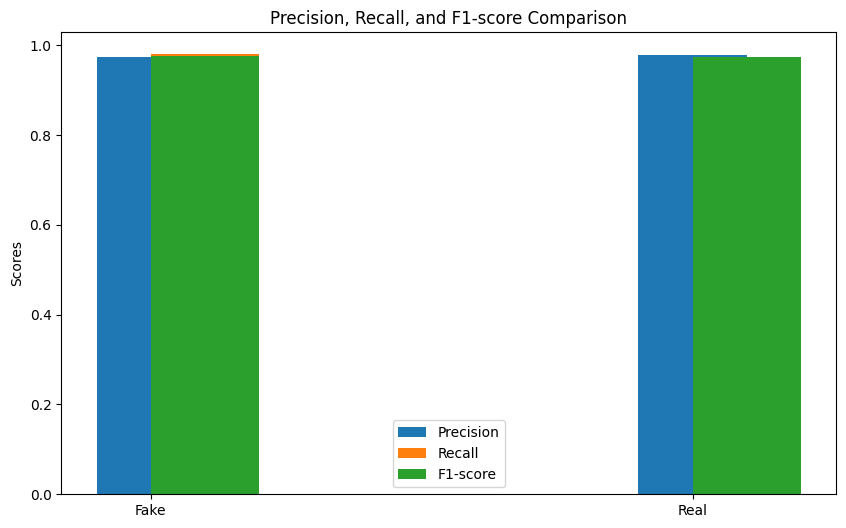

In [ ]:
from sklearn.metrics import classification_report

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
precision = [report['0']['precision'], report['1']['precision']]
recall = [report['0']['recall'], report['1']['recall']]
f1 = [report['0']['f1-score'], report['1']['f1-score']]

# Plotting precision, recall, and F1-score
labels = ['Fake', 'Real']
x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar(x, recall, width=0.2, label='Recall', align='edge')
plt.bar(x, f1, width=0.2, label='F1-score', align='edge')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-score Comparison')
plt.legend()
plt.show()


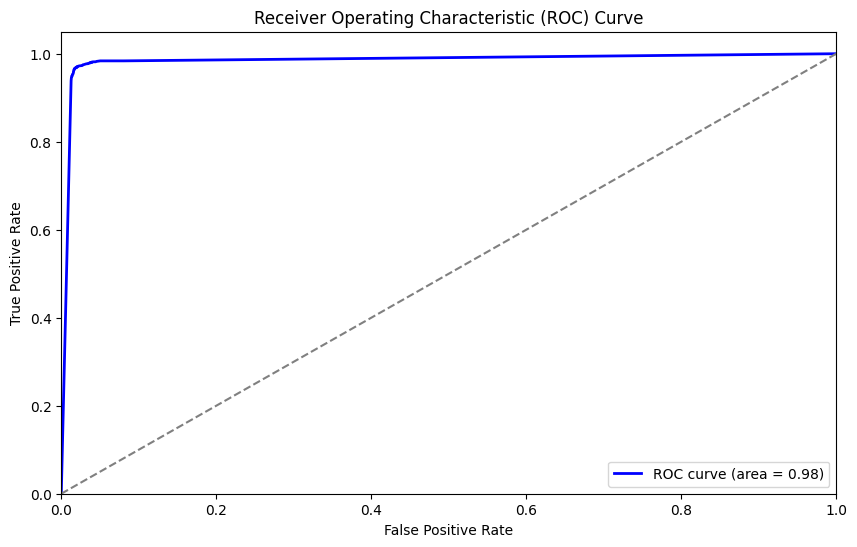

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class (real news)
y_pred_proba = rf_model.predict_proba(lstm_embeddings_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
def check_fake_news(news_text, lstm_model, rf_model, tokenizer, max_len):
    """
    Function to check if the given news article is fake or real.
    Args:
    - news_text: str, the news content to be checked.
    - lstm_model: Trained LSTM model for generating embeddings.
    - rf_model: Trained Random Forest model for classification.
    - tokenizer: Tokenizer fitted on the training data.
    - max_len: int, maximum sequence length used during training.

    Returns:
    - str: 'FAKE' or 'REAL' based on the prediction.
    """
    # Step 1: Preprocess the input text
    cleaned_text = clean_text(news_text)

    # Step 2: Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_len)

    # Step 3: Get LSTM embeddings
    lstm_embedding = lstm_model.predict(padded_seq)

    # Step 4: Predict using Random Forest
    prediction = rf_model.predict(lstm_embedding)

    # Step 5: Interpret the prediction
    return 'FAKE' if prediction[0] == 0 else 'REAL'


# Example usage:
news_article = "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images."
result = check_fake_news(news_article, lstm_model, rf_model, tokenizer, max_len)
print(f"The news article is: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news article is: FAKE


In [ ]:
def check_fake_news(news_text, lstm_model, rf_model, tokenizer, max_len):
    """
    Function to check if the given news article is fake or real.
    Args:
    - news_text: str, the news content to be checked.
    - lstm_model: Trained LSTM model for generating embeddings.
    - rf_model: Trained Random Forest model for classification.
    - tokenizer: Tokenizer fitted on the training data.
    - max_len: int, maximum sequence length used during training.

    Returns:
    - str: 'FAKE' or 'REAL' based on the prediction.
    """
    # Step 1: Preprocess the input text
    cleaned_text = clean_text(news_text)

    # Step 2: Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_len)

    # Step 3: Get LSTM embeddings
    lstm_embedding = lstm_model.predict(padded_seq)

    # Step 4: Predict using Random Forest
    prediction = rf_model.predict(lstm_embedding)

    # Step 5: Interpret the prediction
    return 'FAKE' if prediction[0] == 0 else 'REAL'


# Example usage:
news_article = """ Gandhi is dead
"""
result = check_fake_news(news_article, lstm_model, rf_model, tokenizer, max_len)
print(f"The news article is: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The news article is: FAKE
